# Akita Tutorial: CTCF Disruptions in Genomic Context

This tutorial demonstrates the usage of [akita_utils](https://github.com/Fudenberg-Research-Group/akita_utils) to perform CTCF disruptions in their genomic context. 

This involves:

1. Loading the trained model
2. Opening the relevant genome
3. Reading tsv table with CTCF sites' genomic coordinates
4. Setting up a sequence generator to disrupt CTCF sites at defined genomic positions
5. Making predictions for genomic sequences before and after CTCF disruptions
6. Visualizing the predicted changes in contact maps


In [11]:
import warnings
import os
warnings.filterwarnings("ignore") 

# Suppress TensorFlow logging messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import json
import pandas as pd
import pysam
import tensorflow as tf
from basenji import seqnn, stream

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("/home1/smaruj/akitaX1-analyses/figures/plot_styles/global_plotting_style.mplstyle")

from akita_utils.numpy_utils import ut_dense
from akita_utils.dna_utils import dna_1hot
from akita_utils.seq_gens import central_permutation_seqs_gen

In [12]:
os.environ["CUDA_VISIBLE_DEVICES"] = '-1' ### run on CPU
print(tf.config.list_physical_devices('GPU'))

[]


In [13]:
# arguments 
genome_fasta = "/project/fudenber_735/genomes/mm10/mm10.fa" 
stats = "SCD"
batch_size=8
head_index = 1
model_index = 1
shifts = "0"
rc = False
shifts = [int(shift) for shift in shifts.split(",")]
stats = stats.split(",")
chrom_sizes = "/project/fudenber_735/genomes/mm10/mm10.fa.sizes"

# tsv with coordinates of a few example CTCF sites (range of disruption scores)
CTCT_table = "./disruption_examples.tsv"

models_dir="/project/fudenber_735/tensorflow_models/akita/v2/models"
params_file = models_dir + f"/f{model_index}c0" + "/train" + "/params.json"
model_file = models_dir + f"/f{model_index}c0" + "/train" + f"/model{head_index}_best.h5"
print("params_file: ", params_file)
print("model_file: ", model_file)

chrom_sizes_table = pd.read_csv(chrom_sizes, sep="\t", names=["chrom", "size"])

params_file:  /project/fudenber_735/tensorflow_models/akita/v2/models/f1c0/train/params.json
model_file:  /project/fudenber_735/tensorflow_models/akita/v2/models/f1c0/train/model1_best.h5


### Loading the model

In [14]:
# read model parameters
with open(params_file) as params_open:
    params = json.load(params_open)
params_train = params["train"]
params_model = params["model"]

if batch_size is None:
    batch_size = params_train["batch_size"]
else:
    batch_size = batch_size

# load model
seqnn_model = seqnn.SeqNN(params_model)
seqnn_model.restore(model_file, head_i=head_index)
seqnn_model.build_ensemble(rc, shifts)
seq_length = int(params_model["seq_length"])

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 sequence (InputLayer)       [(None, 1310720, 4)]         0         []                            
                                                                                                  
 stochastic_reverse_complem  ((None, 1310720, 4),         0         ['sequence[0][0]']            
 ent_1 (StochasticReverseCo   ())                                                                 
 mplement)                                                                                        
                                                                                                  
 stochastic_shift_1 (Stocha  (None, 1310720, 4)           0         ['stochastic_reverse_complemen
 sticShift)                                                         t_1[0][0]']             

### Reading the table with disruption parameters

In [15]:
# open genome FASTA
genome_open = pysam.Fastafile(genome_fasta)

### Important Note

The model inputs are provided through a TSV file that lists the genomic positions of CTCF sites. This table is used by the sequence generator to create the sequences that are fed into AkitaV2. The CTCF sites in this file have been carefully prefiltered to ensure they do not overlap with other CTCF sites or repeatable elements.

For this tutorial, we have chosen a set of CTCF sites that demonstrate a range of disruption effects: strong, medium, and weak. 

In [16]:
seq_coords_df = pd.read_csv(CTCT_table, sep="\t")
num_experiments = len(seq_coords_df)

In [17]:
preds_stream = stream.PredStreamGen(
        seqnn_model,
        central_permutation_seqs_gen(seq_coords_df, genome_open, chrom_sizes_table),
        batch_size,
    )

In [18]:
# picking one target
target_index = 1

### Important Note

Maps are displayed in order from CTCF sites with the strongest disruption effects to those with the weakest.

3/3 [==============================] - 23s 6s/step


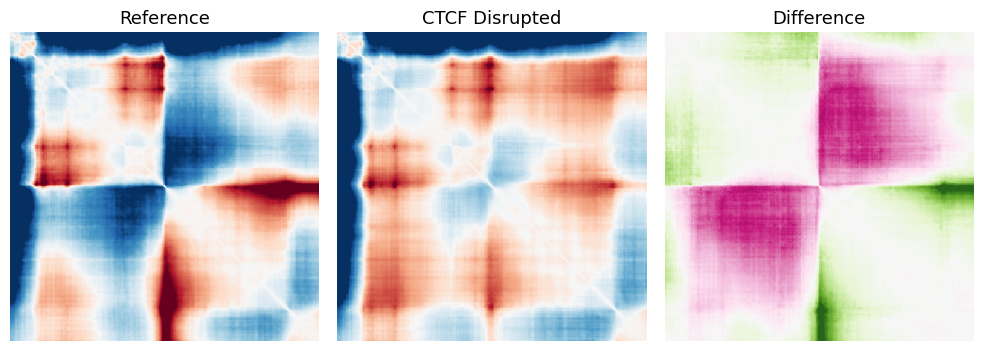

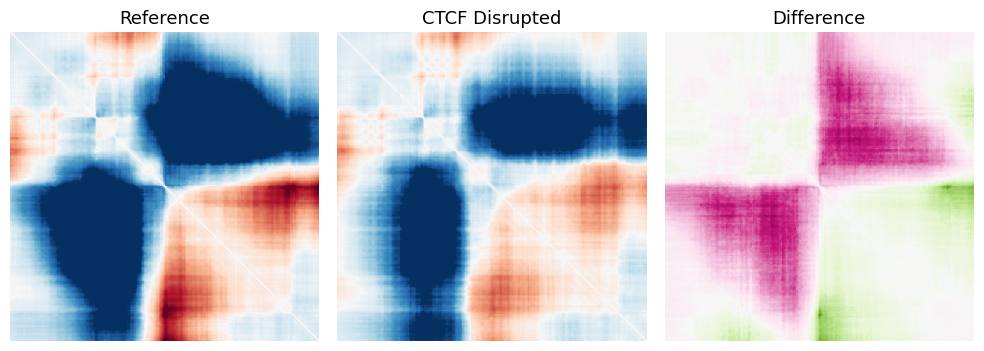

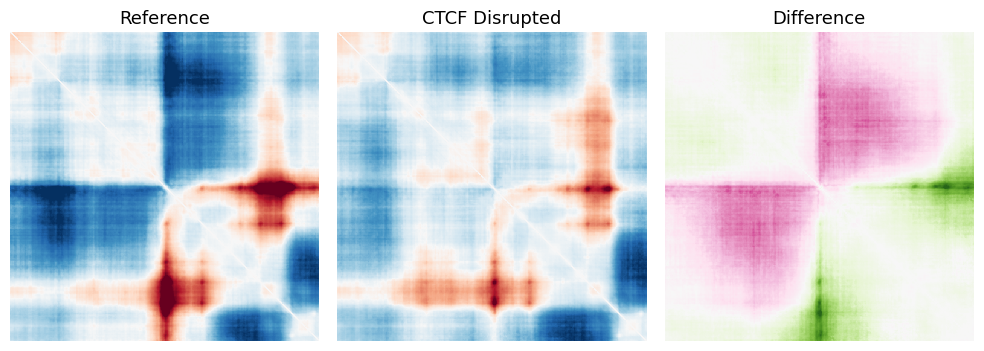

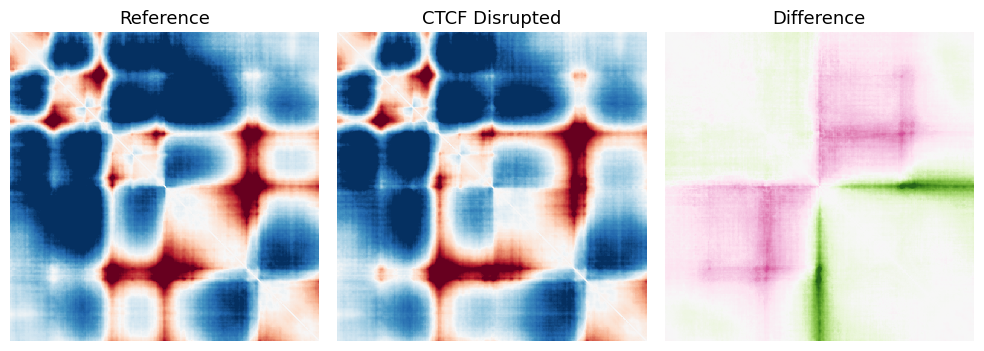

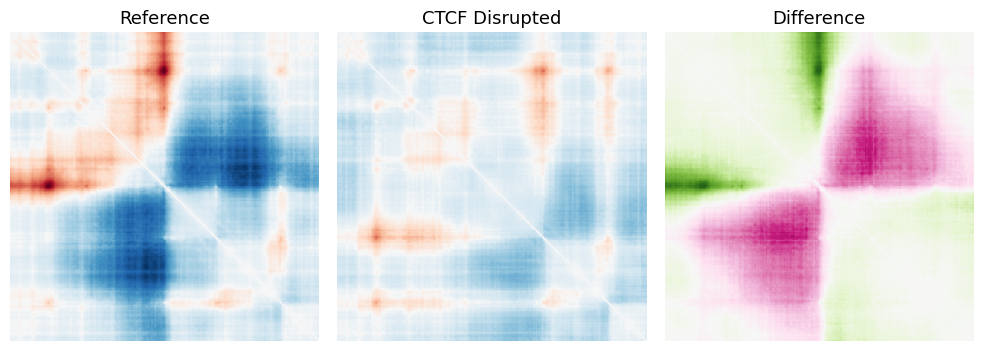

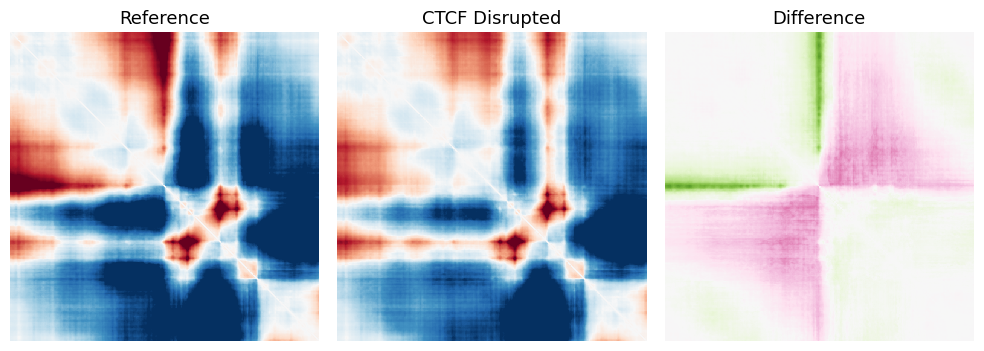

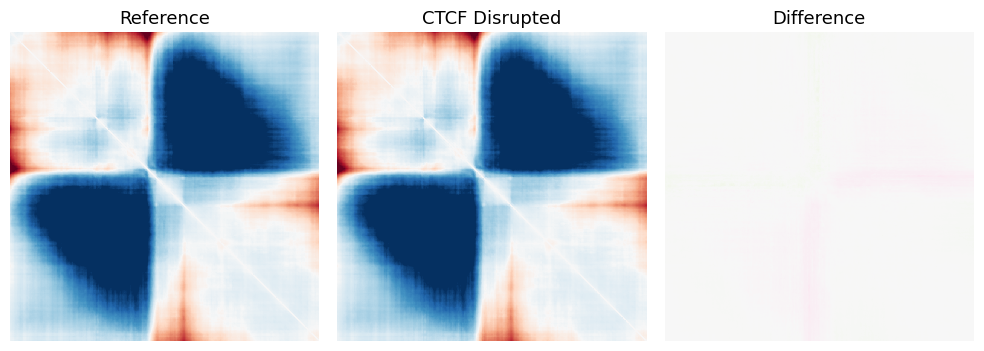

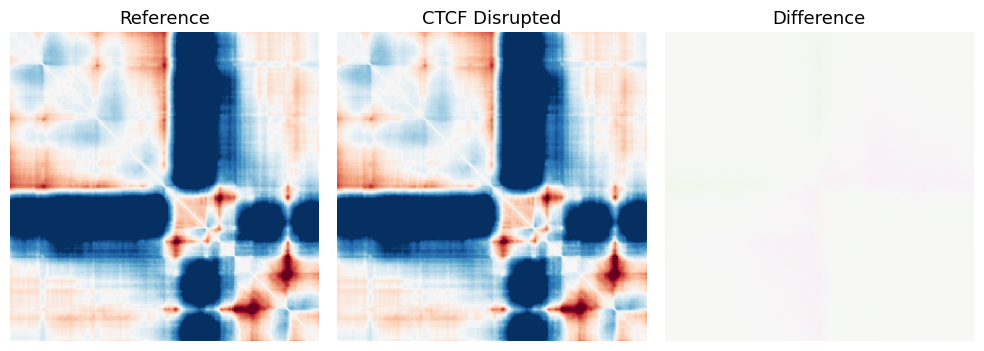

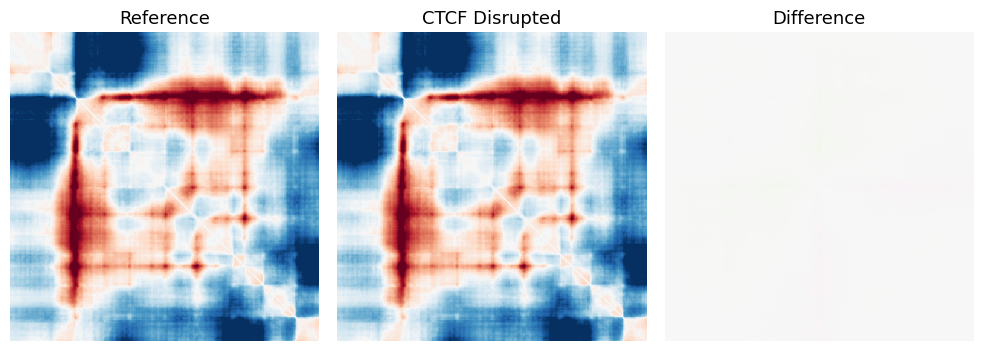

In [19]:
for ref_index in range(0, num_experiments*2, 2):
    
    ref_preds_matrix = preds_stream[ref_index]
    permut_index = ref_index + 1
    permuted_preds_matrix = preds_stream[permut_index]
    exp_index = ref_index//2

    ref_maps = ut_dense(ref_preds_matrix)
    perm_maps = ut_dense(permuted_preds_matrix)

    fig, axs = plt.subplots(1, 3, figsize=(10, 4))
    sns.heatmap(
        ref_maps[:,:,target_index],
        vmin=-0.6,
        vmax=0.6,
        cbar=False,
        cmap="RdBu_r",
        square=True,
        xticklabels=False,
        yticklabels=False,
        ax=axs[0]
    )
    axs[0].set_title('Reference')
    
    sns.heatmap(
        perm_maps[:,:,target_index],
        vmin=-0.6,
        vmax=0.6,
        cbar=False,
        cmap="RdBu_r",
        square=True,
        xticklabels=False,
        yticklabels=False,
        ax=axs[1]
    )
    axs[1].set_title('CTCF Disrupted')

    sns.heatmap(
        perm_maps[:,:,target_index]-ref_maps[:,:,target_index],
        vmin=-0.6,
        vmax=0.6,
        cbar=False,
        cmap="PiYG_r",
        square=True,
        xticklabels=False,
        yticklabels=False,
        ax=axs[2]
    )
    axs[2].set_title('Difference')
    
    plt.tight_layout()
    plt.show()

In [20]:
genome_open.close()